In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from datetime import datetime
import random
import os

import warnings
warnings.filterwarnings(action='ignore') 

In [11]:
# ID 제외 데이터 갖고오기 

train = pd.read_csv('../../DATA/train.csv')
test  = pd.read_csv('../../DATA/test.csv').drop(columns=['ID'])
trade = pd.read_csv('../../DATA/international_trade.csv')

In [12]:
# 데이터 타입 변경, 열 이름 변경 

new_column_names = {
    'corporation': 'corp',
    'location': 'loc',
    'supply(kg)': 'supply',
    'price(원/kg)': 'price',
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

train['timestamp']  = pd.to_datetime(train['timestamp'])
test['timestamp']  = pd.to_datetime(test['timestamp'])



In [22]:
train['item_id'] = train.ID.str[0:6]
# train에서 item_id별로 price 열에 대한 최대 최솟 값을 구해서 새로운 데이터 프레임으로 만들어줘 
price_minmax = train.groupby('item_id')['price'].agg(['min', 'max']).reset_index()
supply_minmax =train.groupby('item_id')['supply'].agg(['min', 'max']).reset_index() 
price_max_dict = price_minmax.set_index('item_id')['max'].to_dict()
supply_max_dict = supply_minmax.set_index('item_id')['max'].to_dict() 

In [23]:

def makenewprice(id, price):
    maxprice = price_max_dict.get(id)
    if maxprice is not None:  # 해당 id가 price_max_dict에 존재하는지 확인
        return price / maxprice
    else:
        return np.nan  # 해당 id가 price_max_dict에 존재하지 않으면 NaN 반환

def makenewsupply(id, supply) :
    maxsupply = supply_max_dict.get(id) 
    if maxsupply is not None :
        return supply/ maxsupply 
    else : 
        return np.nan 
price_scaled = train.apply(lambda row: makenewprice(row['item_id'], row['price']), axis=1)
supply_scaled = train.apply(lambda row : makenewsupply(row['item_id'], row['supply']),axis=1 )

supply_scaled

0        0.000000
1        0.000000
2        0.416593
3        0.171859
4        0.222399
           ...   
59392    0.370003
59393    0.345093
59394    0.313199
59395    0.390268
59396    0.349624
Length: 59397, dtype: float64

In [24]:
train['price'] = price_scaled
train['supply'] = supply_scaled
train

,ID,timestamp,item,corp,loc,supply,price,item_id
0,TG_A_J_20190101,2019-01-01,TG,A,J,0.000000,0.000000,TG_A_J
1,TG_A_J_20190102,2019-01-02,TG,A,J,0.000000,0.000000,TG_A_J
2,TG_A_J_20190103,2019-01-03,TG,A,J,0.416593,0.147642,TG_A_J
3,TG_A_J_20190104,2019-01-04,TG,A,J,0.171859,0.120301,TG_A_J
4,TG_A_J_20190105,2019-01-05,TG,A,J,0.222399,0.106801,TG_A_J
...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,2023-02-27,RD,F,J,0.370003,0.312417,RD_F_J
59393,RD_F_J_20230228,2023-02-28,RD,F,J,0.345093,0.354473,RD_F_J
59394,RD_F_J_20230301,2023-03-01,RD,F,J,0.313199,0.383178,RD_F_J
59395,RD_F_J_20230302,2023-03-02,RD,F,J,0.390268,0.349132,RD_F_J


In [4]:
# 데이터 타입 변경, 열 이름 변경 

new_column_names = {
    'corporation': 'corp',
    'location': 'loc',
    'supply(kg)': 'supply',
    'price(원/kg)': 'price',
}

train = train.rename(columns=new_column_names)
test = test.rename(columns=new_column_names)

train['timestamp']  = pd.to_datetime(train['timestamp'])
test['timestamp']  = pd.to_datetime(test['timestamp'])




In [152]:
# train의 날짜 정보 추출하기 

train['year'] = train['timestamp'].dt.year
train['month'] = train['timestamp'].dt.month


train['day'] = train['timestamp'].dt.day
train['weekday'] = train['timestamp'].dt.weekday
# train['quarter'] = train['timestamp'].dt.quarter

def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

# 'month' 칼럼을 정수형으로 변환
train['month'] = train['month'].astype(int)
# test['month'] = test['month'].astype(int)

# 함수를 적용하여 'season' 칼럼 생성
train['season'] = train['month'].apply(month_to_season)
# test['season'] = test['month'].apply(month_to_season




# train['weekofyear'] = train['timestamp'].dt.we # 해당 년도의 몇 주차 
train['dayofyear'] = train['timestamp'].dt.dayofyear #해당 년도의 몇 일째 
train['days_in_month'] = train['timestamp'].dt.days_in_month

In [104]:

average_supply = train.groupby(['year', 'month', 'item', 'corp','loc'])['supply'].mean().reset_index()
average_supply[average_supply['item']== 'TG'].head(20)

,year,month,item,corp,loc,supply
29,2019,1,TG,A,J,23069.290323
30,2019,1,TG,A,S,97903.709677
31,2019,1,TG,B,J,28248.741935
32,2019,1,TG,B,S,59528.145161
33,2019,1,TG,C,J,18558.758065
34,2019,1,TG,C,S,139251.022581
35,2019,1,TG,D,J,22611.129032
36,2019,1,TG,D,S,21529.193548
37,2019,1,TG,E,J,30486.064516
38,2019,1,TG,E,S,33153.516129


In [91]:
emptydays  = ['2019-01-01',  '2019-02-05', '2019-02-06', '2019-09-13', '2019-09-14', '2020-01-01', '2020-01-25', '2020-01-27', '2020-10-01', '2020-10-02', '2020-10-03', '2021-01-01', '2021-02-12', '2021-02-13', 
'2021-09-20', '2021-09-21', '2021-09-22', '2022-01-01', '2022-01-31', '2022-02-01', '2022-02-02', '2022-09-10', '2022-09-12', '2023-01-23', '2023-01-24']
# 25일에 해당하는 값들을 보간해야해 
emptydays = [datetime.strptime(day, "%Y-%m-%d") for day in emptydays]

In [92]:
for i in range(len(train)) :
    if train.loc[i, 'timestamp'] in emptydays :
        # print(train.loc[i, 'timestamp'])
        year,month,item, corp, loc = train.loc[i,'year'],train.loc[i,'month'],train.loc[i,'item'],train.loc[i,'corp'],train.loc[i,'loc']
        newprice = average_price[(average_price['year']==year) & (average_price['month']==month) & (average_price['item']==item) & (average_price['corp']==corp) & (average_price['loc']==loc)]['price']
        print(newprice.values[0])
        train.loc[i,'price'] = newprice.values[0]
        

1737.7407407407406
2051.7083333333335
2051.7083333333335
2119.68
2119.68
1591.7037037037037
1591.7037037037037
1591.7037037037037
1183.5925925925926
1183.5925925925926
1183.5925925925926
1295.923076923077
1452.4583333333333
1452.4583333333333
5005.692307692308
5005.692307692308
5005.692307692308
1734.4615384615386
1734.4615384615386
2539.625
2539.625
6036.7692307692305
6036.7692307692305
1819.8461538461538
1819.8461538461538
2134.925925925926
2696.2083333333335
2696.2083333333335
4445.28
4445.28
1631.7407407407406
1631.7407407407406
1631.7407407407406
1781.037037037037
1781.037037037037
1781.037037037037
2087.3076923076924
2698.7083333333335
2698.7083333333335
4276.538461538462
4276.538461538462
4276.538461538462
2756.576923076923
2756.576923076923
2682.2083333333335
2682.2083333333335
5024.7692307692305
5024.7692307692305
2246.153846153846
2246.153846153846
1413.7407407407406
1966.6666666666667
1966.6666666666667
4576.68
4576.68
1265.851851851852
1265.851851851852
1265.851851851852
11

In [97]:
empty_rows = train['timestamp'].isin(emptydays)
empty_train = train.loc[empty_rows, ['year', 'month', 'item', 'corp', 'loc','price']]
empty_train

,year,month,item,corp,loc,price
0,2019,1,TG,A,J,1737.740741
35,2019,2,TG,A,J,2051.708333
36,2019,2,TG,A,J,2051.708333
255,2019,9,TG,A,J,2119.680000
256,2019,9,TG,A,J,2119.680000
...,...,...,...,...,...,...
59002,2022,2,RD,F,J,419.375000
59222,2022,9,RD,F,J,0.000000
59224,2022,9,RD,F,J,0.000000
59357,2023,1,RD,F,J,434.346154


In [83]:
empty_rows = train['timestamp'].isin(emptydays)
empty_train = train.loc[empty_rows, ['year', 'month', 'item', 'corp', 'loc']]
filled_price = pd.merge(empty_train, average_price, on=['year', 'month', 'item', 'corp','loc'], how='left')
# 원래 데이터프레임에서 'price' 값을 채움
train.loc[empty_rows, 'price'] = filled_price

In [85]:
empty_rows = train['timestamp'].isin(emptydays)
empty_train = train.loc[empty_rows, ['year', 'month', 'item', 'corp', 'loc','price']]
empty_train



,year,month,item,corp,loc,price
0,2019,1,TG,A,J,1737.740741
35,2019,2,TG,A,J,1781.037037
36,2019,2,TG,A,J,2087.307692
255,2019,9,TG,A,J,543.111111
256,2019,9,TG,A,J,543.111111
...,...,...,...,...,...,...
59002,2022,2,RD,F,J,NaN
59222,2022,9,RD,F,J,NaN
59224,2022,9,RD,F,J,NaN
59357,2023,1,RD,F,J,NaN


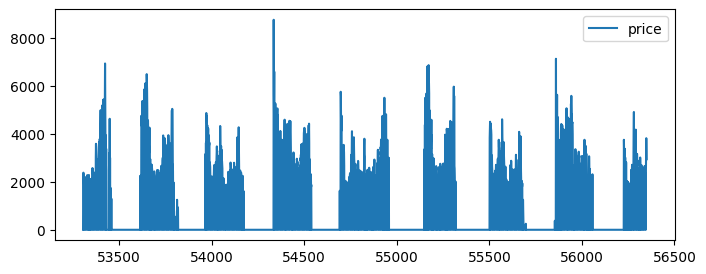

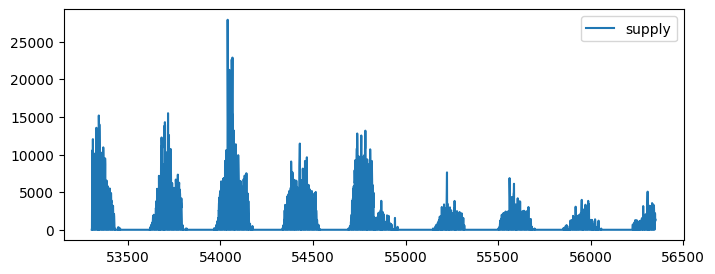

In [7]:
newtrain =train.set_index('timestamp')
newtrain = train[(train['item']== 'BC') & (train['corp']== 'E') ] 
newtrain[['price']].plot(figsize= (8,3)) 
newtrain[['supply']].plot(figsize= (8,3)) 
# plt.title(f"Price trend for : {col_name} {tosee}")
plt.show() 

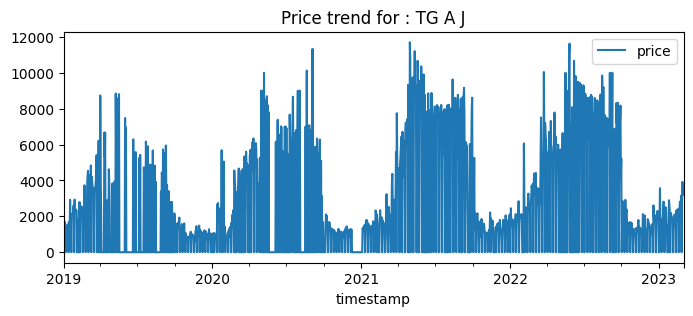

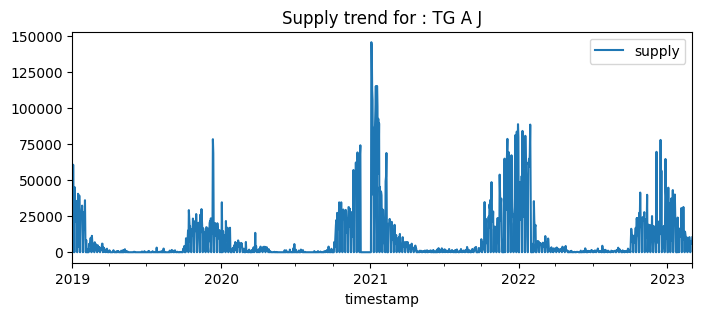

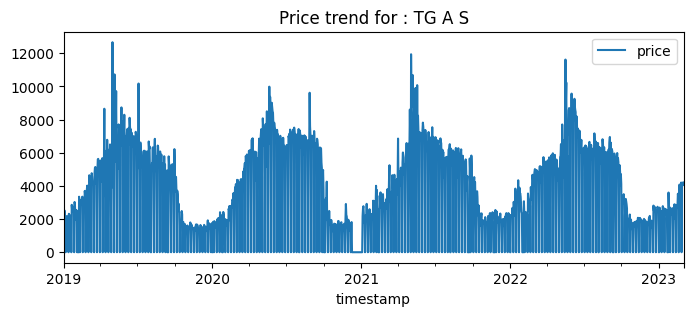

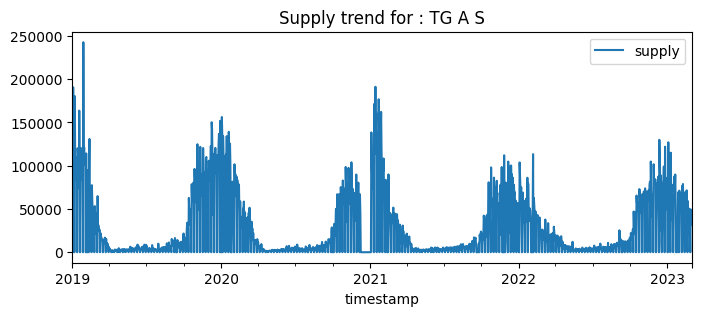

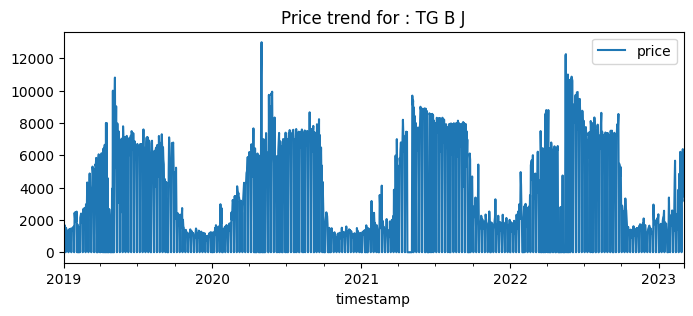

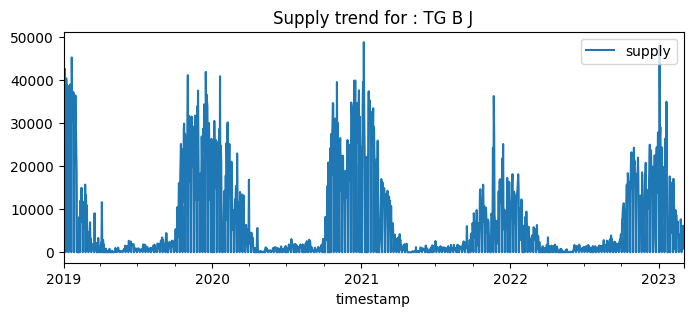

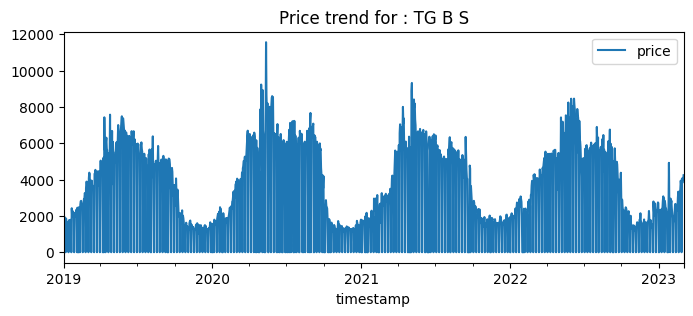

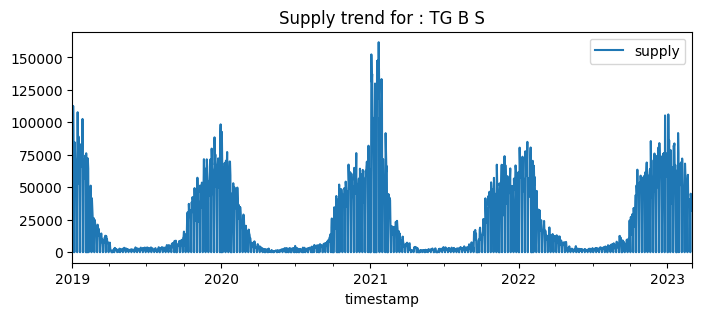

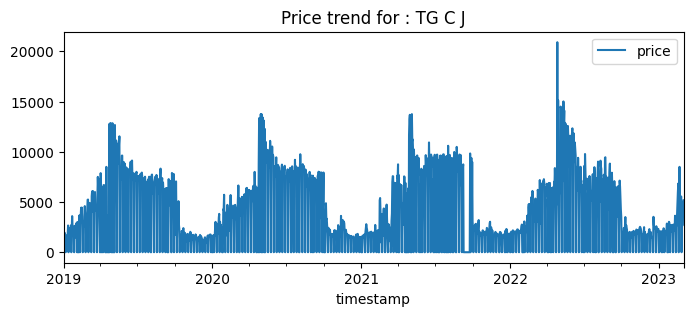

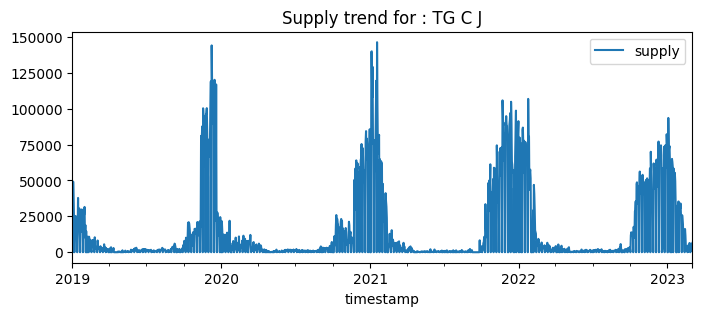

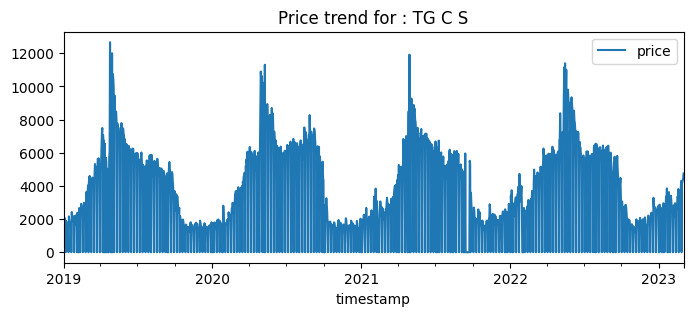

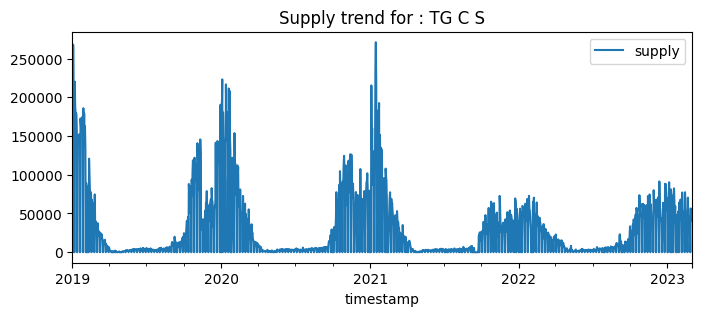

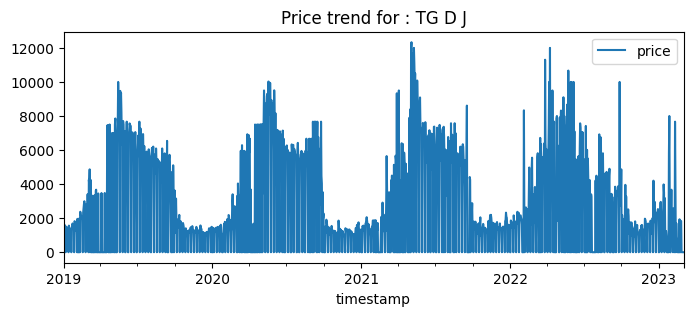

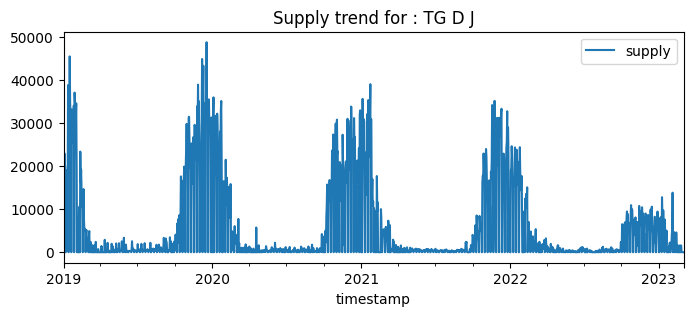

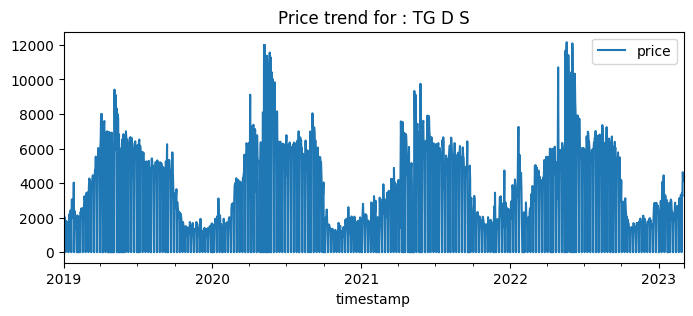

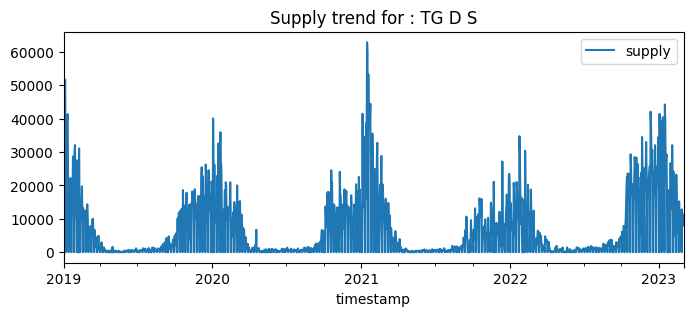

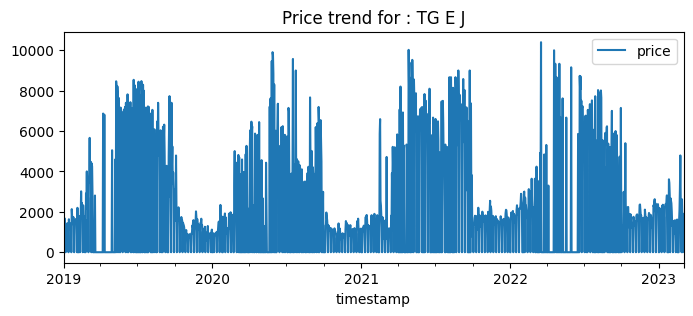

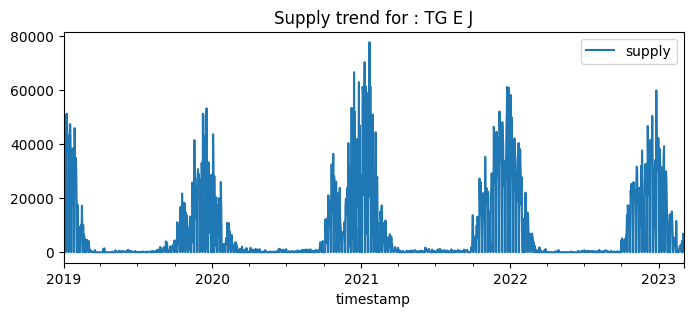

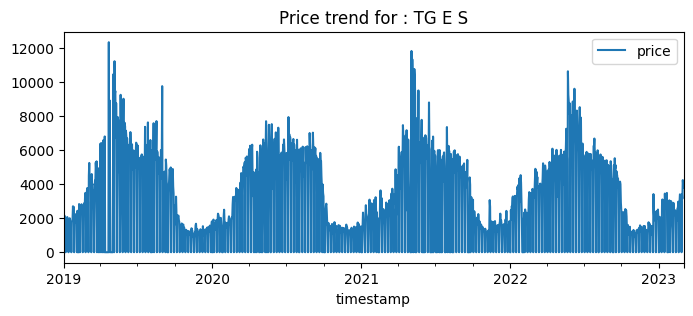

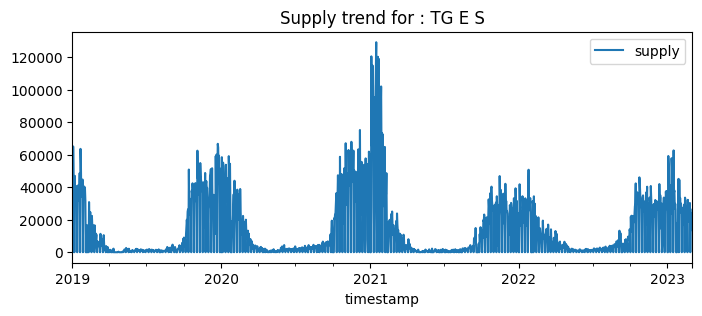

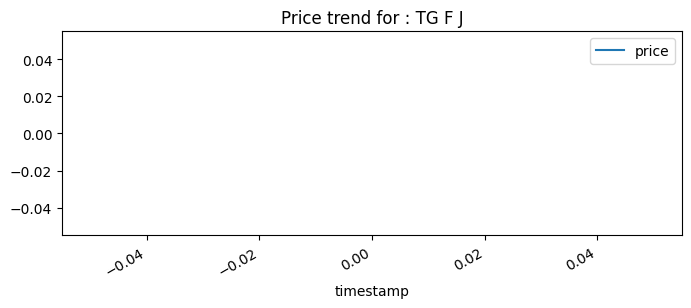

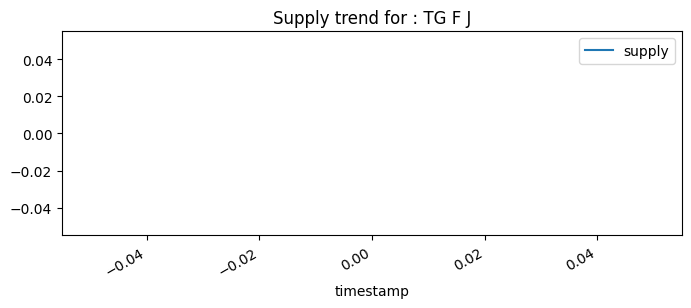

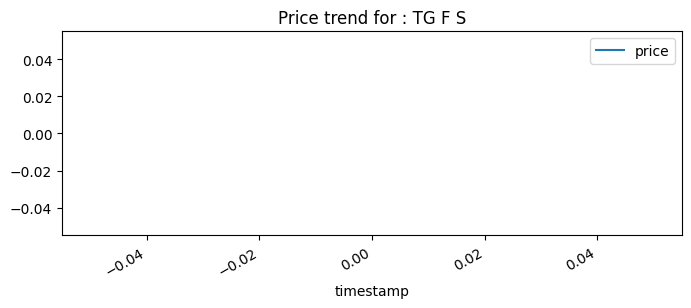

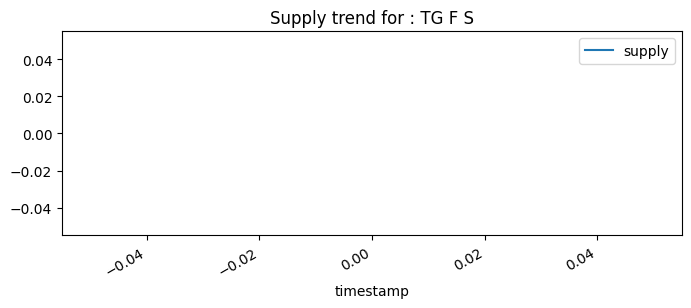

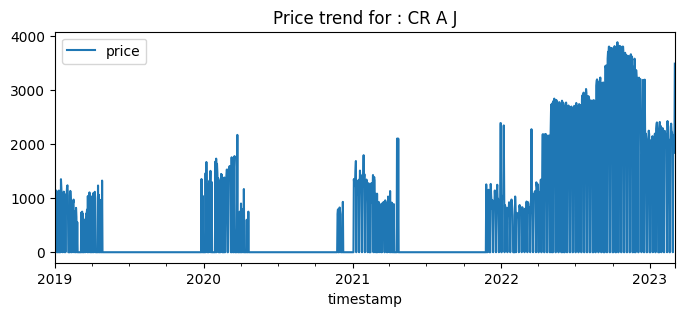

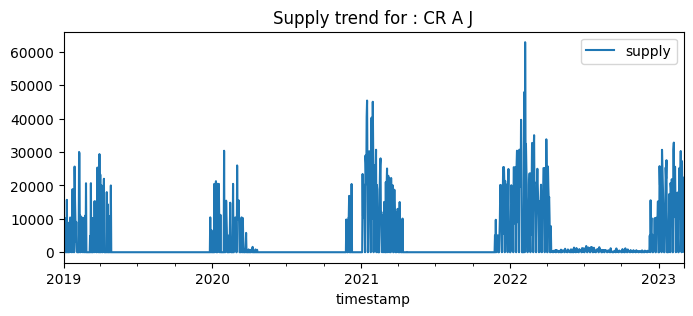

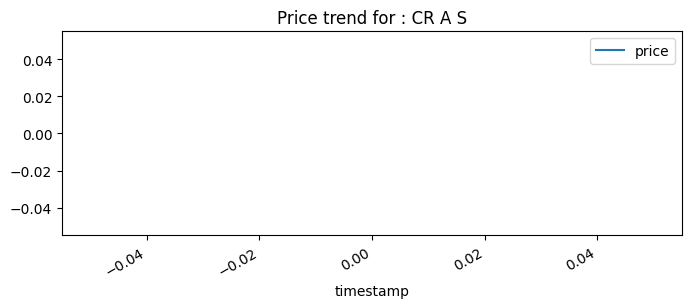

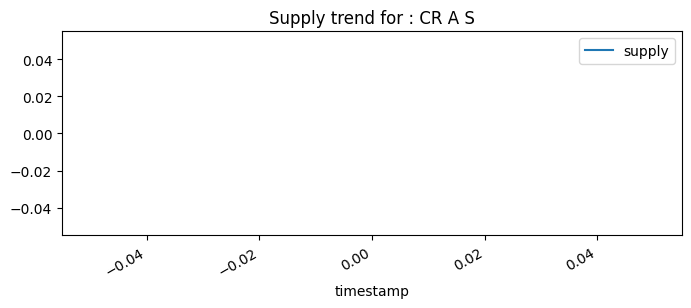

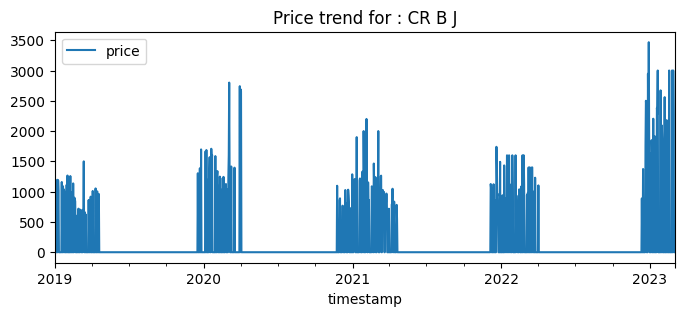

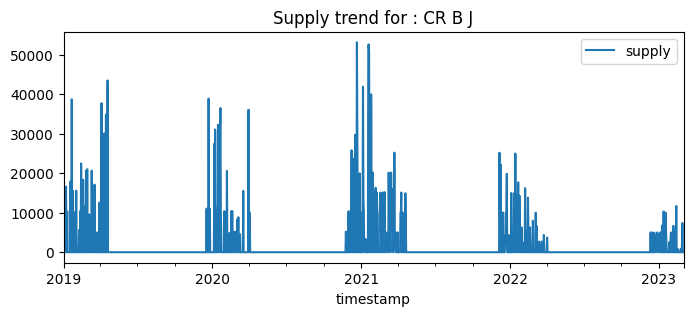

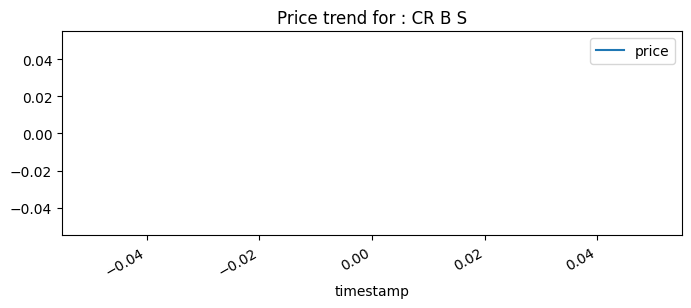

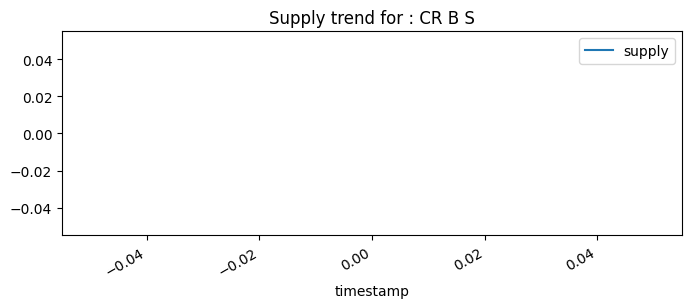

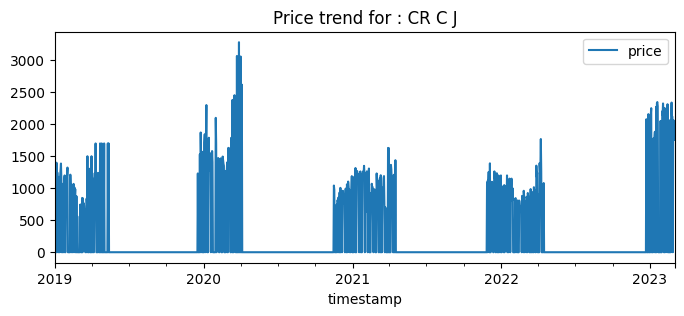

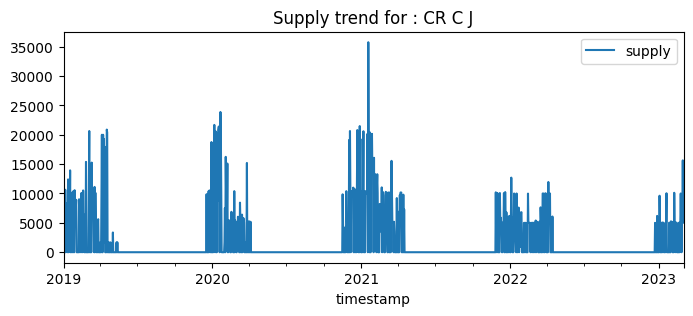

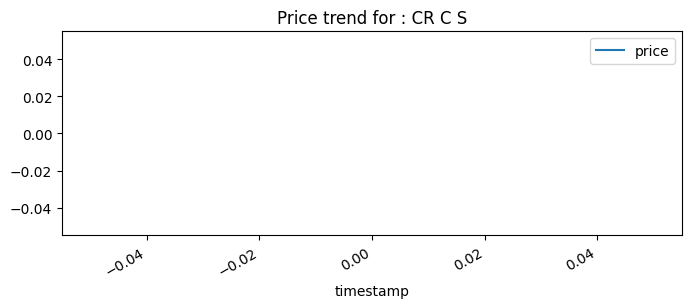

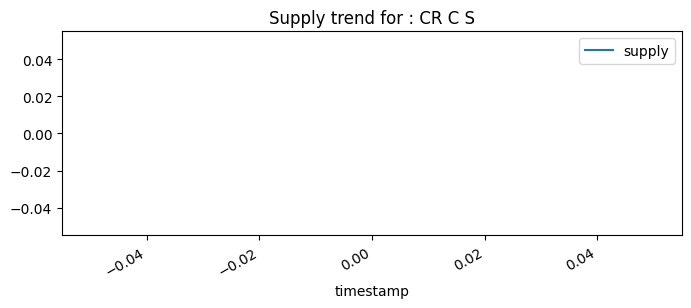

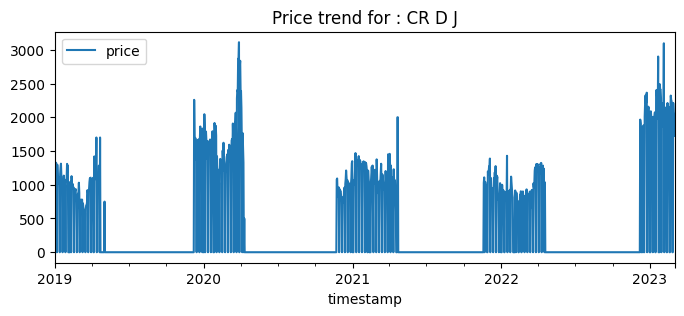

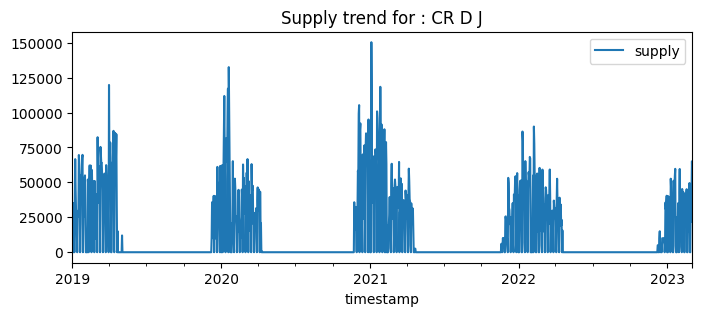

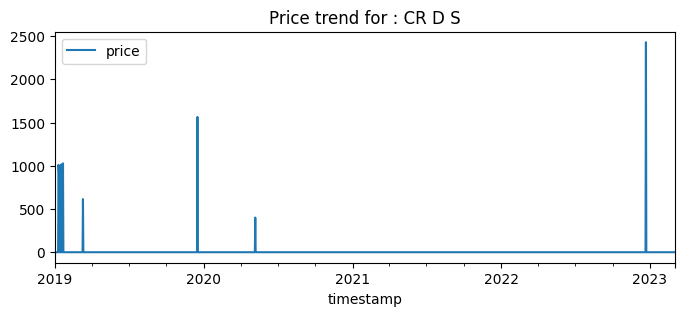

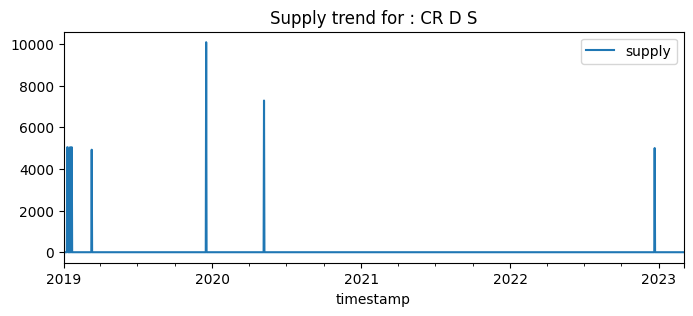

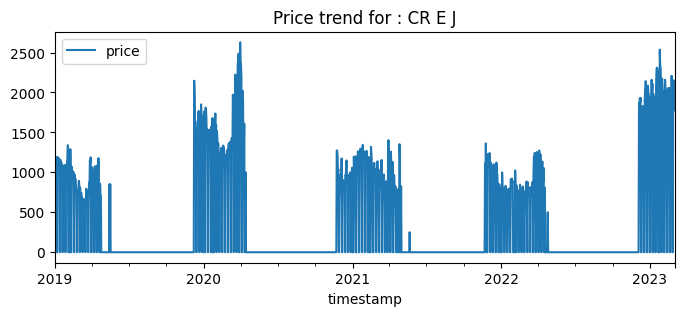

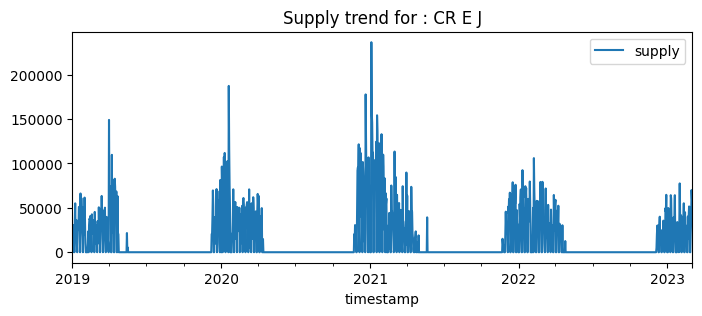

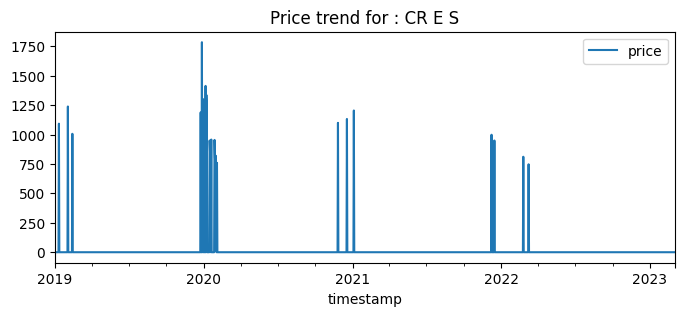

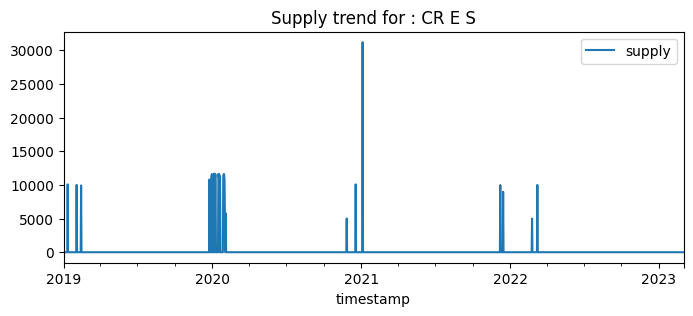

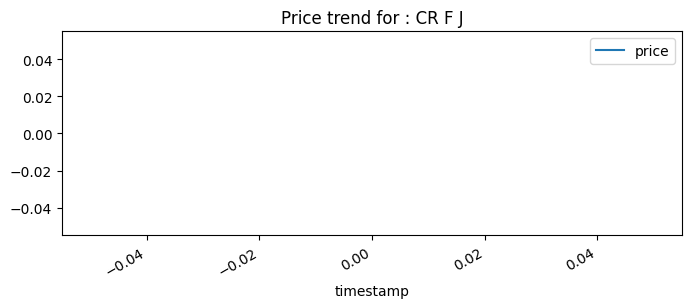

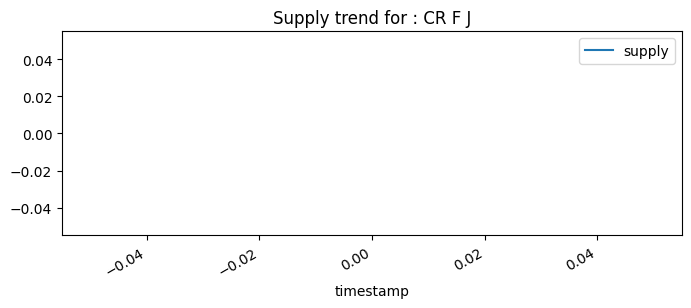

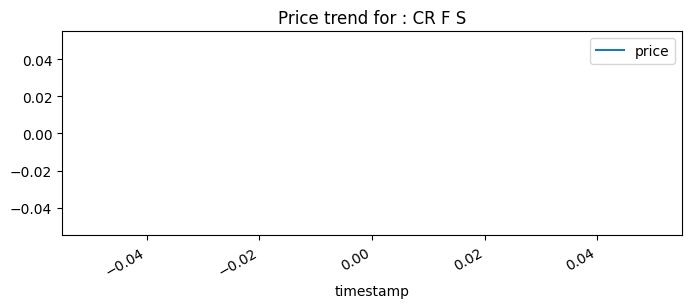

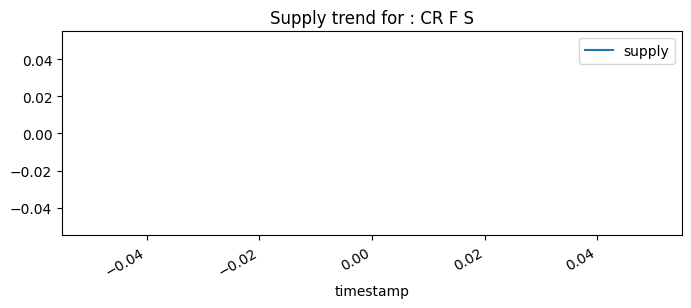

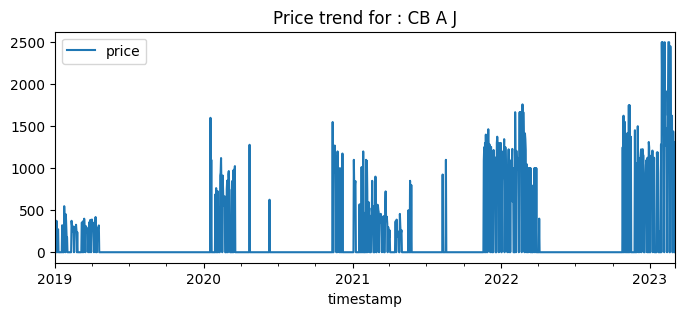

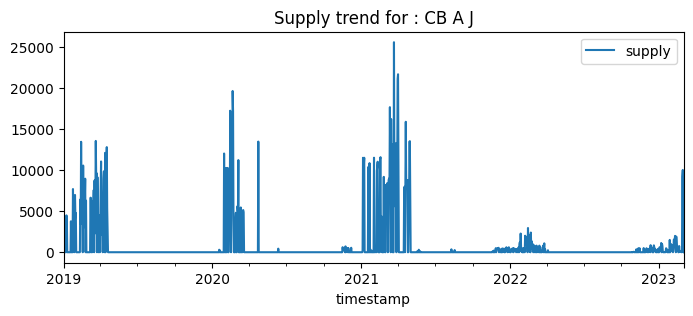

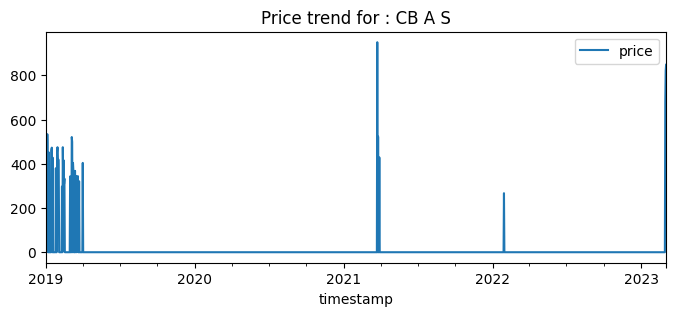

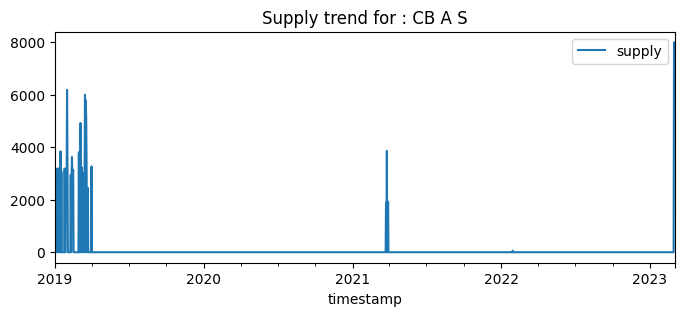

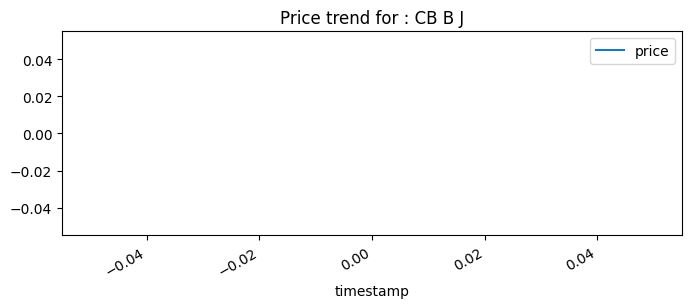

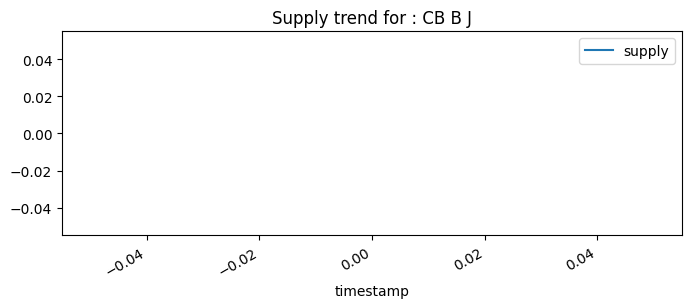

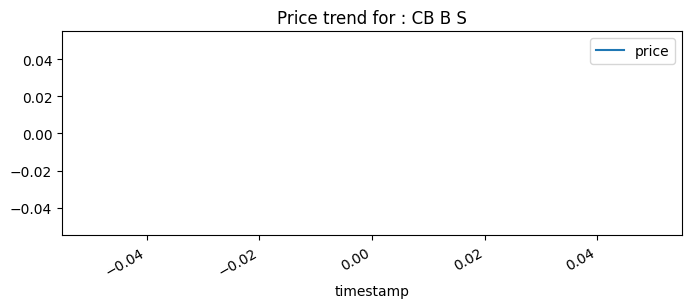

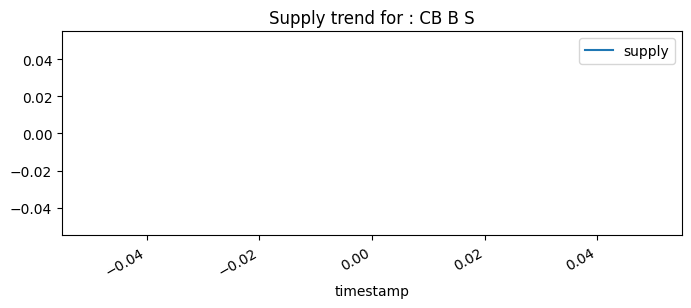

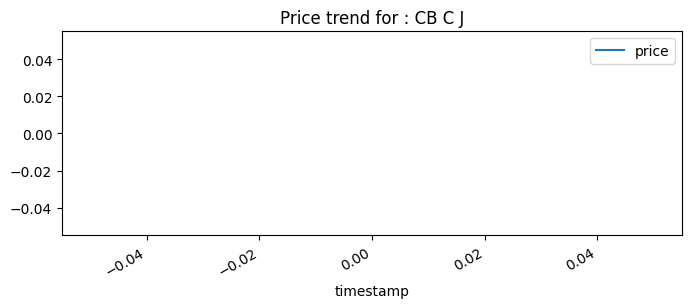

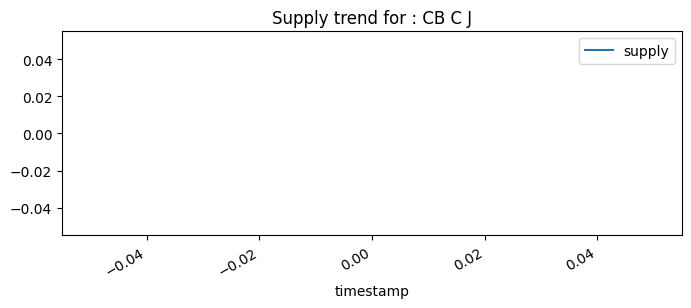

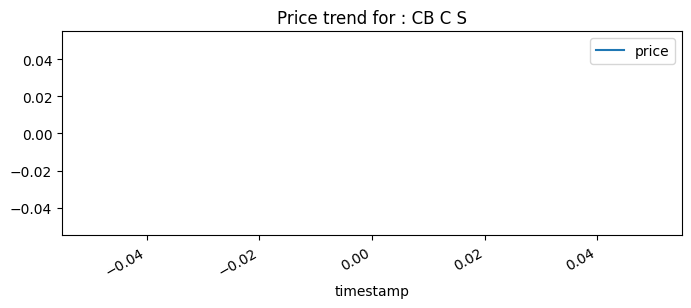

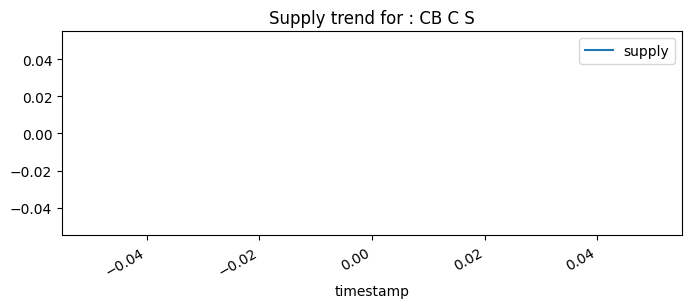

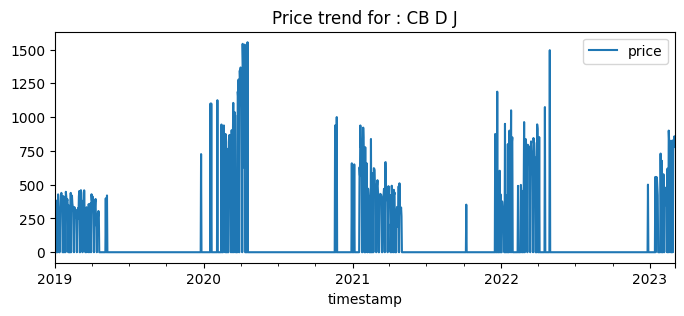

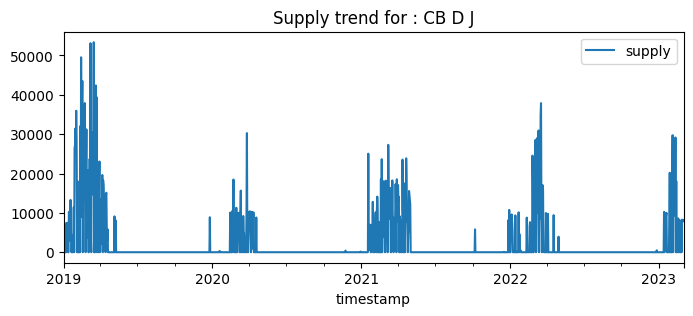

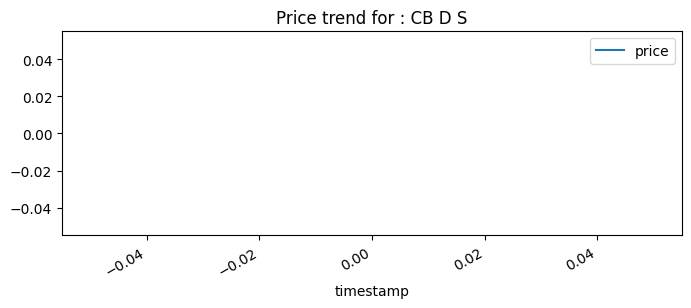

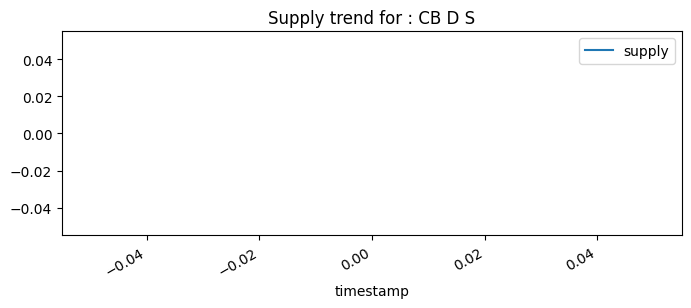

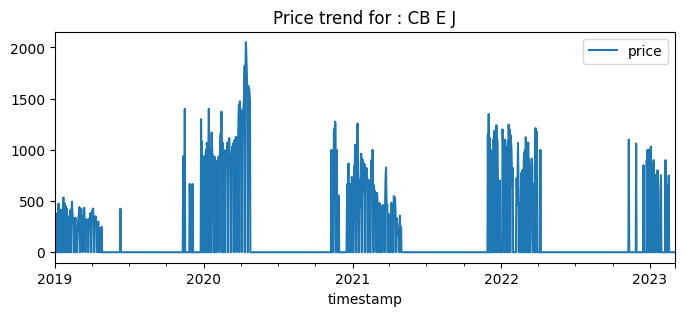

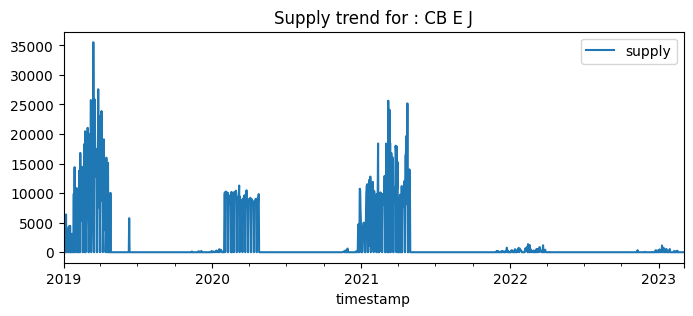

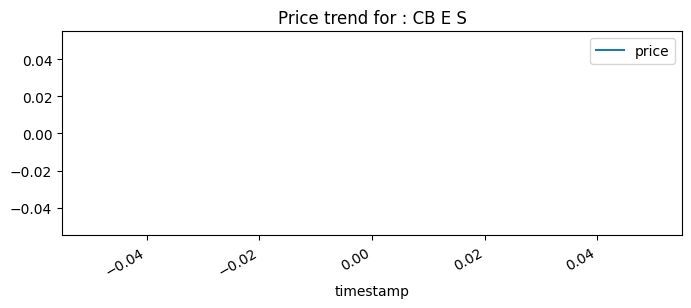

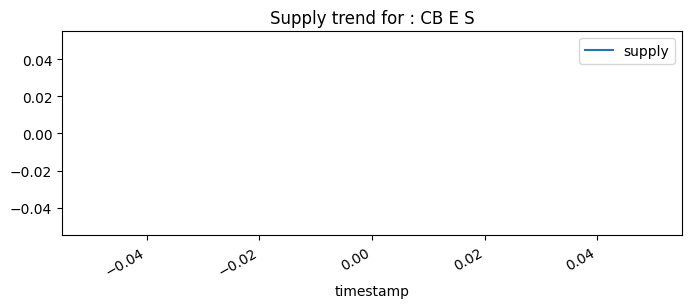

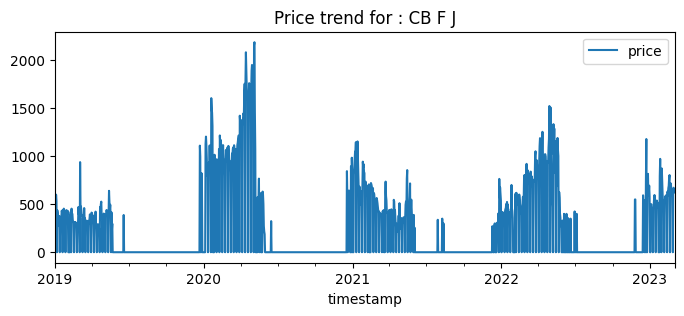

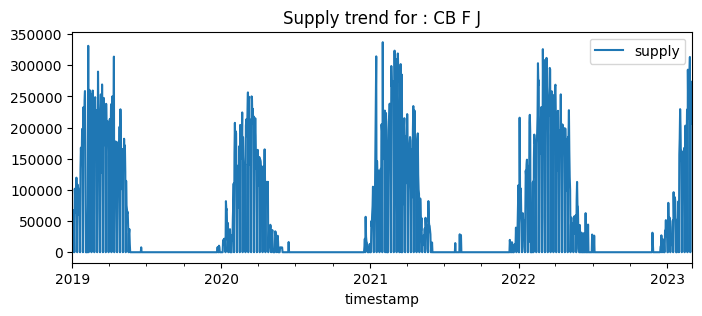

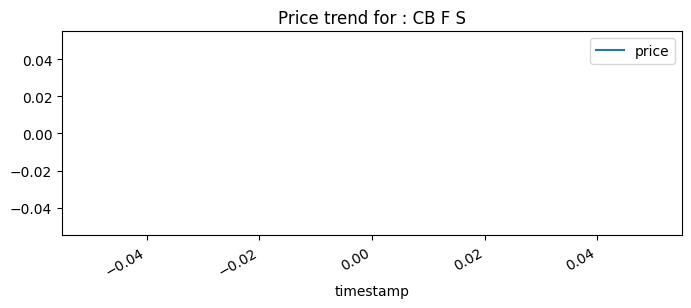

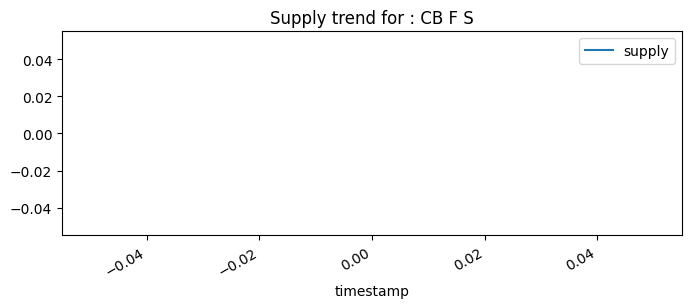

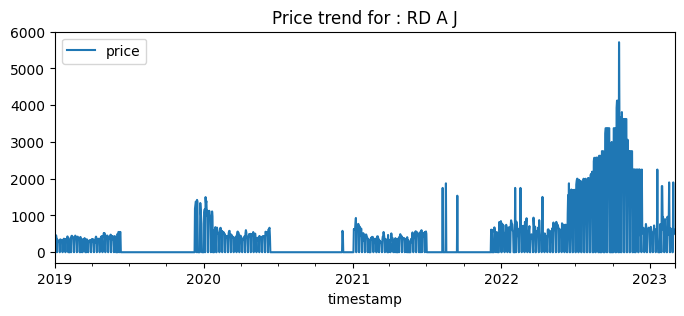

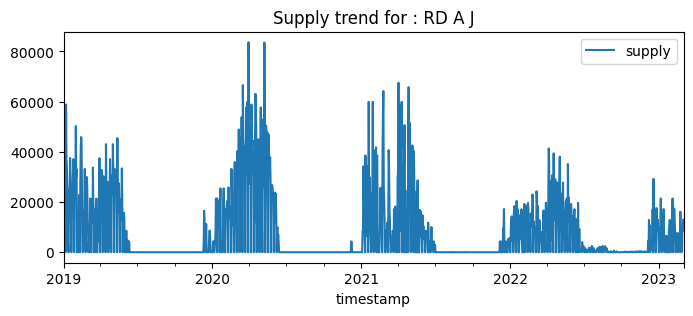

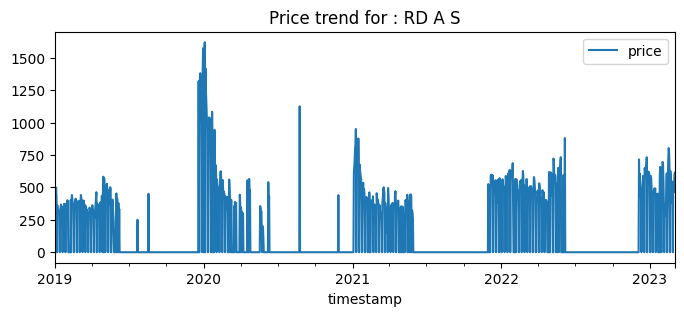

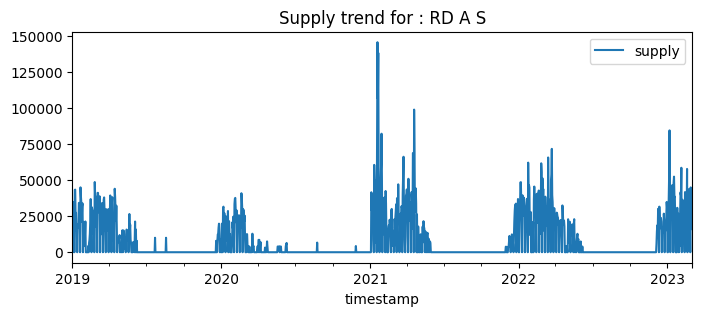

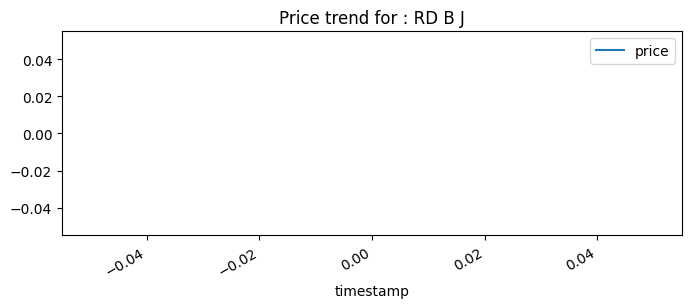

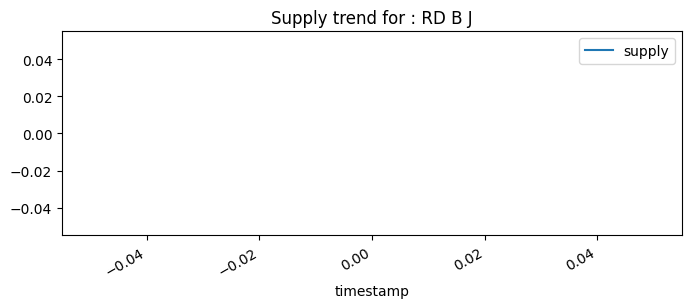

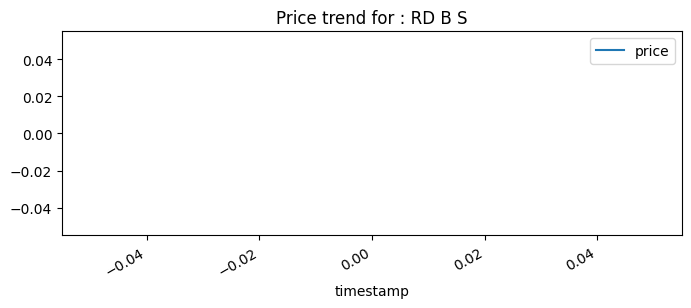

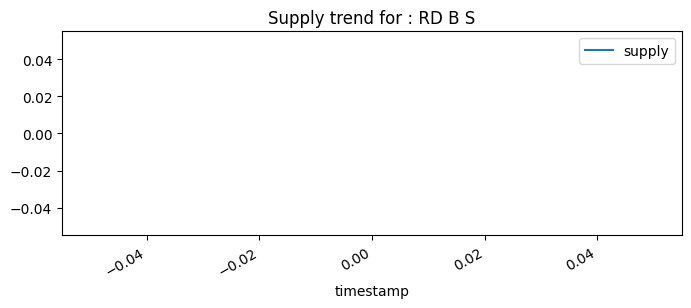

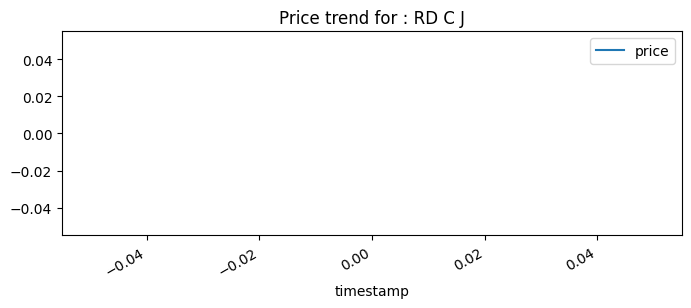

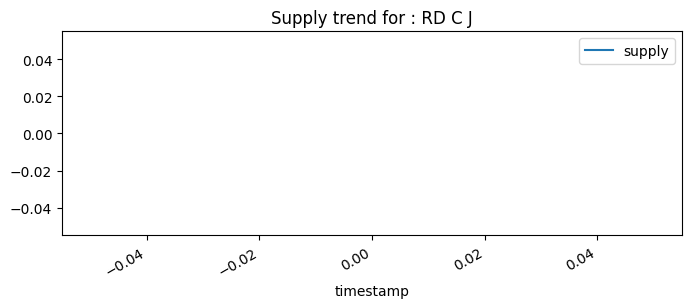

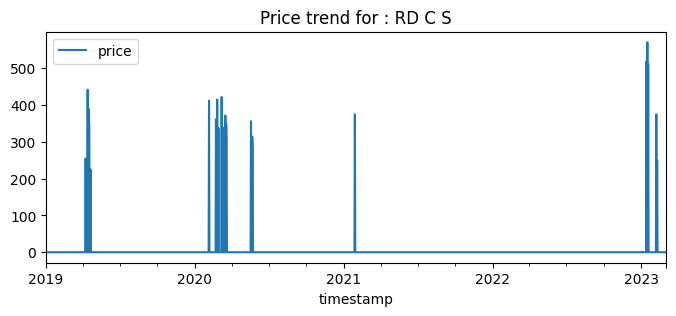

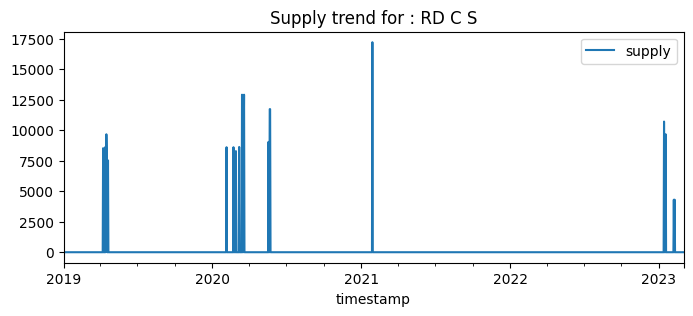

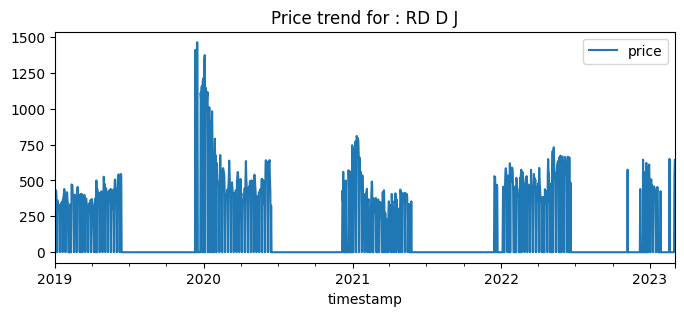

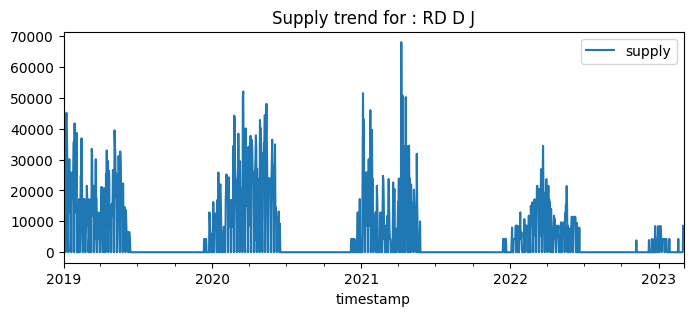

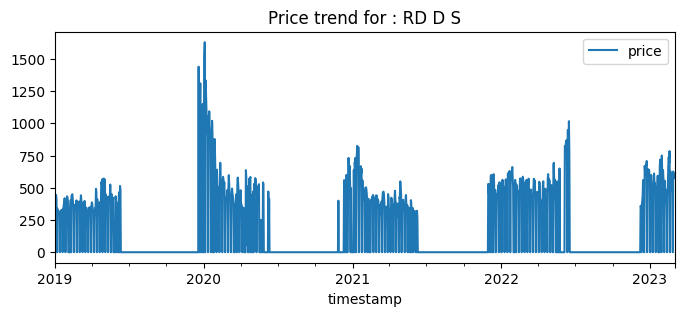

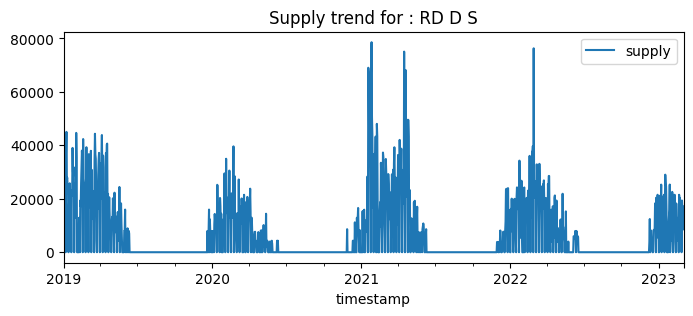

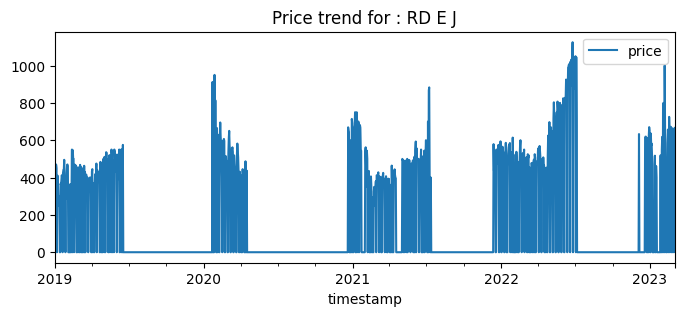

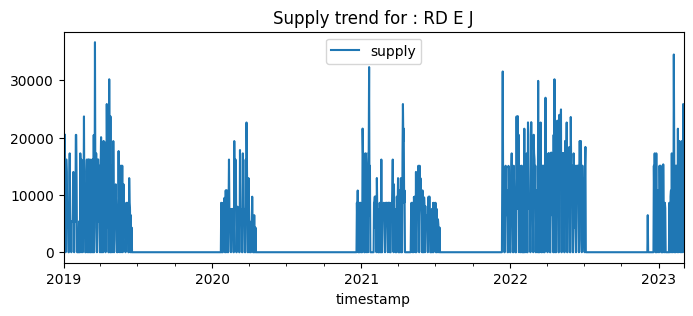

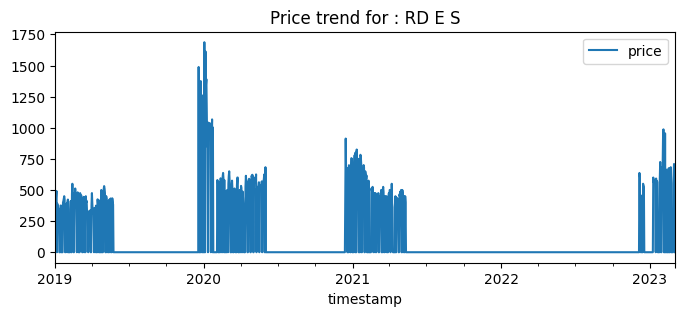

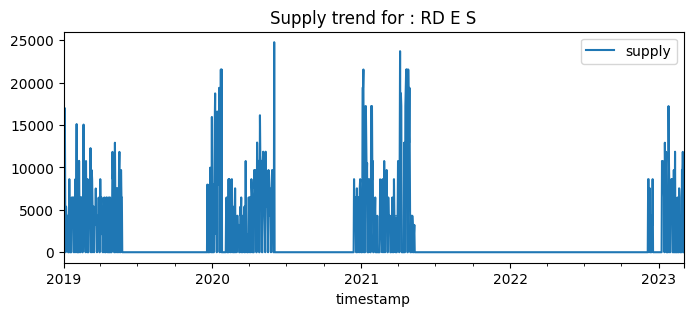

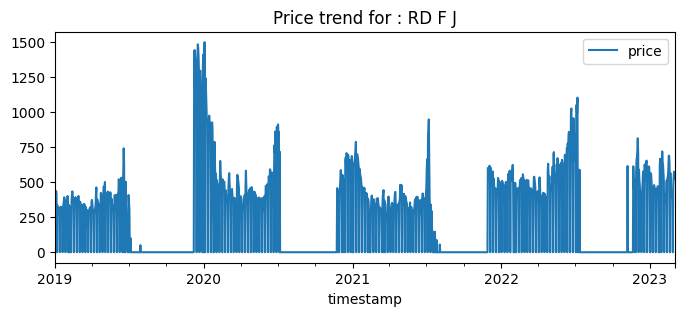

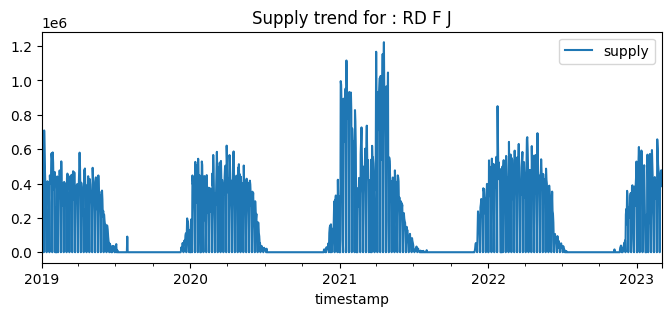

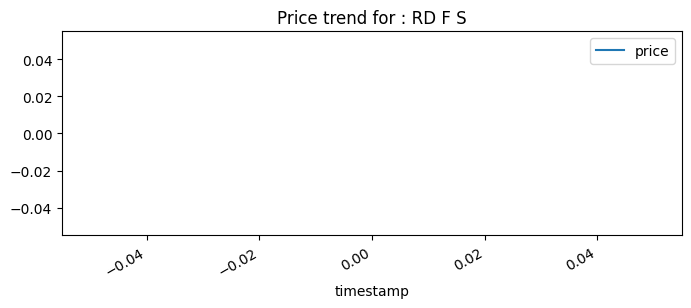

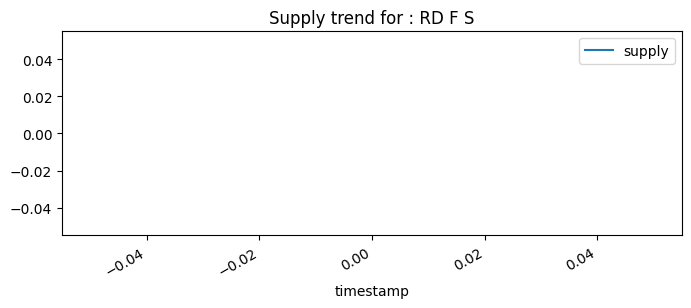

In [146]:
# TG, BC는 계절성을 잘 따르고 규칙있다 
# 이상치 : RDC , bcbs bccs 
# 물가 상승 :CBA
# 예측 이상(낮게나옴/높게나옴) : tgbj , tgej craj, crbj / bcbs bccs
import matplotlib.pyplot as plt

def plot_function(data, col_name, tosee, col_name2, tosee2, col_name3, tosee3 ) :
    
    newdata = data[(data[col_name]== tosee )& (data[col_name2]== tosee2) &(data[col_name3]== tosee3)] 
    newdata = newdata.set_index('timestamp')
    newdata[['price']].plot(figsize= (8,3)) 
    plt.title(f"Price trend for : {tosee} {tosee2} {tosee3}")
    plt.show() 
    
    newdata[['supply']].plot(figsize= (8,3)) 
    plt.title(f"Supply trend for : {tosee} {tosee2} {tosee3}")
    plt.show() 
    

# plot_function(train,'item','RD','corp', 'F' , 'loc' , 'J')

for item in ['TG','CR', 'CB',  'RD']:
    for corp in ['A', 'B', 'C', 'D', 'E', 'F']:
        for loc in ['J', 'S']:
            plot_function(train, 'item' , item, 'corp', corp , 'loc', loc )

In [155]:
train

,timestamp,item,corp,loc,supply,price,year,month,day,weekday,season,dayofyear,days_in_month
0,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,Winter,1,31
1,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,Winter,2,31
2,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,Winter,3,31
3,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,Winter,4,31
4,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,Winter,5,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,0,Winter,58,28
59393,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,1,Winter,59,28
59394,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,2,Spring,60,31
59395,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,3,Spring,61,31


In [158]:
import pandas as pd

# Assuming you have a DataFrame named 'train' containing the columns 'item', 'corp', and 'loc'
train['item_corp_loc']= train['item'].str.cat([train['corp'], train['loc']], sep='')
train['item_corp']= train['item'].str.cat([train['corp']], sep='')
# train['item_loc']= train['item'].str.cat([train['loc']], sep='')
train['y_it_loc_m'] = train['item'].str.cat([train['loc'], train['year'].astype(str),train['month'].astype(str)], sep = '')

In [159]:
test['item_corp_loc']= test['item'].str.cat([test['corp'], test['loc']], sep='')
test['item_corp']= test['item'].str.cat([test['corp']], sep='')
# test['item_loc']= test['item'].str.cat([test['loc']], sep='')
test['y_it_loc_m'] = test['item'].str.cat([test['loc'], test['year'].astype(str),test['month'].astype(str)], sep = '')

KeyError: 'year'

In [114]:
test

,timestamp,item,corp,loc,item_corp_loc,item_corp,item_loc
0,2023-03-04,TG,A,J,TGAJ,TGA,TGJ
1,2023-03-05,TG,A,J,TGAJ,TGA,TGJ
2,2023-03-06,TG,A,J,TGAJ,TGA,TGJ
3,2023-03-07,TG,A,J,TGAJ,TGA,TGJ
4,2023-03-08,TG,A,J,TGAJ,TGA,TGJ
...,...,...,...,...,...,...,...
1087,2023-03-27,RD,F,J,RDFJ,RDF,RDJ
1088,2023-03-28,RD,F,J,RDFJ,RDF,RDJ
1089,2023-03-29,RD,F,J,RDFJ,RDF,RDJ
1090,2023-03-30,RD,F,J,RDFJ,RDF,RDJ


# test에 supply 열 생성하기 => 각 상품별로 23년 2,3월의 공급량의 median을 집어넣기 

In [135]:
from sklearn import base
from sklearn.model_selection import KFold

class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,colnames,targetName, n_fold=5, verbosity=True,    discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold , shuffle = True, random_state=42)
        col_mean_name = self.colnames + '_' + 'TarEnc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] =  X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {}    is {}.'.format(col_mean_name,self.targetName, np.corrcoef(X[self.targetName].values,encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
        return X

In [136]:
target_encoder = KFoldTargetEncoderTrain('item_loc' ,'price',n_fold=5 )

In [137]:
newtrain  = target_encoder.fit_transform(train)

Correlation between the new feature, item_loc_TarEnc and, price    is 0.6139104258203091.


In [138]:
newtrain

,timestamp,item,corp,loc,supply,price,year,month,day,weekday,...,dayofyear,days_in_month,is_mon_start,is_mon_end,item_corp_loc,item_corp,item_loc,corp_Kfold_Target_Enc,item_Kfold_Target_Enc,item_loc_TarEnc
0,2019-01-01,TG,A,J,0.0,0.0,2019,1,1,1,...,1,31,True,False,TGAJ,TGA,TGJ,1149.840619,3179.621443,3012.845659
1,2019-01-02,TG,A,J,0.0,0.0,2019,1,2,2,...,2,31,False,False,TGAJ,TGA,TGJ,1149.840619,3179.621443,3012.845659
2,2019-01-03,TG,A,J,60601.0,1728.0,2019,1,3,3,...,3,31,False,False,TGAJ,TGA,TGJ,1133.796573,3181.847501,3019.062459
3,2019-01-04,TG,A,J,25000.0,1408.0,2019,1,4,4,...,4,31,False,False,TGAJ,TGA,TGJ,1145.836875,3164.229788,2983.713216
4,2019-01-05,TG,A,J,32352.0,1250.0,2019,1,5,5,...,5,31,False,False,TGAJ,TGA,TGJ,1133.699144,3185.031170,3006.342951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,2023-02-27,RD,F,J,452440.0,468.0,2023,2,27,0,...,58,28,False,False,RDFJ,RDF,RDJ,266.219032,189.136029,256.779773
59393,2023-02-28,RD,F,J,421980.0,531.0,2023,2,28,1,...,59,28,False,True,RDFJ,RDF,RDJ,259.108749,186.274301,249.470890
59394,2023-03-01,RD,F,J,382980.0,574.0,2023,3,1,2,...,60,31,True,False,RDFJ,RDF,RDJ,266.219032,189.136029,256.779773
59395,2023-03-02,RD,F,J,477220.0,523.0,2023,3,2,3,...,61,31,False,False,RDFJ,RDF,RDJ,266.219032,189.136029,256.779773


In [78]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})

        return X

In [139]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    def __init__(self,train,colNames,encodedName):
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean = self.train[[self.colNames,
        self.encodedName]].groupby(
        self.colNames).mean().reset_index()
        dd = {}
        for row in (mean.itertuples(index=False)):
            dd[row[0]] = row[1]
            X[self.encodedName] = X[self.colNames]
            X[self.encodedName] = X[self.encodedName].map(dd.get)
        return X

In [143]:
fortestencod = KFoldTargetEncoderTest(train, colNames='item_loc' , encodedName='item_loc_TarEnc')

In [144]:
newtest = fortestencod.fit_transform(test)

In [145]:
newtest

,timestamp,item,corp,loc,item_corp_loc,item_corp,item_loc,item_loc_TarEnc
0,2023-03-04,TG,A,J,TGAJ,TGA,TGJ,3006.728889
1,2023-03-05,TG,A,J,TGAJ,TGA,TGJ,3006.728889
2,2023-03-06,TG,A,J,TGAJ,TGA,TGJ,3006.728889
3,2023-03-07,TG,A,J,TGAJ,TGA,TGJ,3006.728889
4,2023-03-08,TG,A,J,TGAJ,TGA,TGJ,3006.728889
...,...,...,...,...,...,...,...,...
1087,2023-03-27,RD,F,J,RDFJ,RDF,RDJ,251.952664
1088,2023-03-28,RD,F,J,RDFJ,RDF,RDJ,251.952664
1089,2023-03-29,RD,F,J,RDFJ,RDF,RDJ,251.952664
1090,2023-03-30,RD,F,J,RDFJ,RDF,RDJ,251.952664


In [65]:

# train는 주어진 데이터 프레임을 가정합니다.
train['timestamp'] = pd.to_datetime(train['timestamp'])  # 'timestamp'를 datetime으로 변환

# 원하는 기간 동안의 데이터 필터링
start_date = pd.to_datetime("2023-02-01")
end_date = pd.to_datetime("2023-03-03")
mask = (train['timestamp'] >= start_date) & (train['timestamp'] <= end_date)
filtered_train = train.loc[mask]

# 'item_corp_loc' 별로 'supply'의 중앙값 계산
result = filtered_train.groupby('item_corp_loc')['supply'].median()

In [71]:
median_df = result.reset_index().rename(columns={'supply': 'supply'})
median_df

,item_corp_loc,supply
0,BCAJ,10248.0
1,BCAS,4464.0
2,BCBJ,984.0
3,BCBS,0.0
4,BCCJ,264.0
5,BCCS,0.0
6,BCDJ,2360.0
7,BCEJ,6640.0
8,BCES,2104.0
9,CBAJ,360.0


In [74]:
test['supply'] = 0 
test['item_corp_loc']= test['item'].str.cat([test['corp'], test['loc']], sep='')
test = pd.merge(test, median_df, on ='item_corp_loc', how = 'left' )
test

,timestamp,item,corp,loc,supply_x,item_corp_loc,supply_y
0,2023-03-04,TG,A,J,0,TGAJ,10094.8
1,2023-03-05,TG,A,J,0,TGAJ,10094.8
2,2023-03-06,TG,A,J,0,TGAJ,10094.8
3,2023-03-07,TG,A,J,0,TGAJ,10094.8
4,2023-03-08,TG,A,J,0,TGAJ,10094.8
...,...,...,...,...,...,...,...
1087,2023-03-27,RD,F,J,0,RDFJ,425040.0
1088,2023-03-28,RD,F,J,0,RDFJ,425040.0
1089,2023-03-29,RD,F,J,0,RDFJ,425040.0
1090,2023-03-30,RD,F,J,0,RDFJ,425040.0


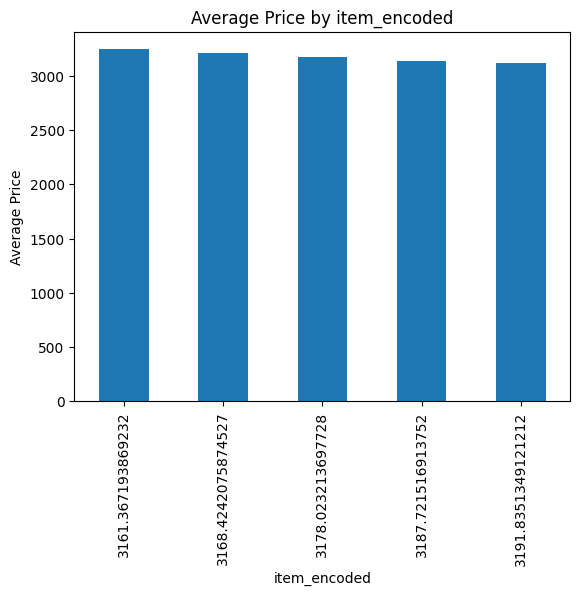

item_encoded
3161.367194    3243.964912
3168.424208    3213.424640
3178.023214    3175.151201
3187.721517    3135.898709
3191.835135    3121.373192
Name: price, dtype: float64

In [152]:
RD_train  = train[train['item'] =='TG']
avprice = RD_train.groupby('item_encoded')['price'].mean()
avprice.plot(kind='bar')
plt.xlabel('item_encoded')
plt.ylabel('Average Price')
plt.title('Average Price by item_encoded')
plt.show()
avprice

In [136]:
avprice

item_encoded
184.644447    196.808878
186.423283    189.643902
187.990231    183.448150
188.020195    183.271717
188.286065    182.138161
Name: price, dtype: float64

,timestamp,item,corp,loc,item_encoded
0,2023-03-04,TG,A,J,3177.603178
1,2023-03-05,TG,A,J,3177.603178
2,2023-03-06,TG,A,J,3177.603178
3,2023-03-07,TG,A,J,3177.603178
4,2023-03-08,TG,A,J,3177.603178
...,...,...,...,...,...
1087,2023-03-27,RD,F,J,187.070064
1088,2023-03-28,RD,F,J,187.070064
1089,2023-03-29,RD,F,J,187.070064
1090,2023-03-30,RD,F,J,187.070064
